# 🚗 Cityscapes Dataset - Exploration et Analyse des Données (EDA)

## 🎯 Contexte et Objectifs

Dans le cadre du développement d'un système embarqué de vision par ordinateur pour véhicules autonomes chez **Future Vision Transport**, nous devons créer un modèle de segmentation sémantique capable d'identifier et de classifier les différents éléments d'une scène urbaine en temps réel.

**Contexte métier** : Notre équipe R&D développe la partie segmentation d'images (module 3) qui s'intègre dans une chaîne complète :
1. 📷 Acquisition des images en temps réel
2. 🔧 Traitement des images (Franck)
3. 🎯 **Segmentation des images (NOUS)**
4. 🧠 Système de décision (Laura)

**Objectif principal** : Explorer et analyser le dataset Cityscapes pour :
- Comprendre la structure et la composition des données
- Analyser la distribution des 30 classes originales
- Créer un mapping intelligent vers 8 catégories principales
- Préparer les artefacts nécessaires pour l'entraînement du modèle
- Identifier les défis et opportunités pour l'optimisation

**Contraintes techniques** :
- Le modèle doit être optimisé pour l'embarqué (contraintes de mémoire et vitesse)
- Nous devons nous concentrer sur 8 catégories principales plutôt que 30 sous-catégories
- L'API finale doit être simple d'utilisation pour Laura (système de décision)

---

## 📚 Imports et Configuration

Avant de commencer notre exploration, nous devons importer toutes les librairies nécessaires pour :
- **Manipulation des données** : numpy, pandas pour l'analyse statistique
- **Visualisation** : matplotlib, seaborn, plotly pour créer des graphiques informatifs
- **Traitement d'images** : PIL, OpenCV, scikit-image pour charger et analyser les annotations
- **Utilitaires** : pathlib pour la gestion des chemins, json pour sauvegarder les configurations

Ici, nous allons également configurer l'environnement de visualisation pour obtenir des graphiques de qualité professionnelle.

In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd
from pathlib import Path
import json
from collections import Counter, defaultdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Image processing
import cv2
from PIL import Image
import skimage.io as io
from skimage import measure

# Progress bars
from tqdm.auto import tqdm

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Imports réalisés avec succès!")

✅ Imports réalisés avec succès!


**Note technique** : Nous utilisons `warnings.filterwarnings('ignore')` pour éviter les alertes non-critiques durant l'exploration. En production, ces warnings devraient être analysés individuellement.

## 🗂️ Configuration des Chemins et Constantes

À ce stade, nous devons définir la structure de notre projet et vérifier l'accessibilité de nos données.

**Organisation du projet** :
- `PROJECT_ROOT` : Racine du projet contenant tous nos dossiers
- `DATA_ROOT` : Dossier contenant le dataset Cityscapes
- `GTFINE_ROOT` : Annotations fines (masks de segmentation) - **disponibles**
- `LEFTIMG_ROOT` : Images originales - **à vérifier/télécharger**

Nous créons également les dossiers de sortie pour organiser nos résultats :
- `figures/` : Toutes les visualisations générées
- `outputs/` : Fichiers CSV, JSON et rapports d'analyse

Cette organisation nous permettra de maintenir un workflow propre et reproductible.

In [2]:
# Chemins principaux
PROJECT_ROOT = Path("C:/Tonton/OpenClassrooms/Projet_7_traiter_images_systeme_embarque_voiture_autonome")
DATA_ROOT = PROJECT_ROOT / "data"
GTFINE_ROOT = DATA_ROOT / "gtFine"
LEFTIMG_ROOT = DATA_ROOT / "leftImg8bit"  # À vérifier si disponible

# Créer les dossiers nécessaires
os.makedirs(PROJECT_ROOT / "notebooks" / "figures", exist_ok=True)
os.makedirs(PROJECT_ROOT / "notebooks" / "outputs", exist_ok=True)

FIGURES_DIR = PROJECT_ROOT / "notebooks" / "figures"
OUTPUTS_DIR = PROJECT_ROOT / "notebooks" / "outputs"

print(f"📁 Projet racine: {PROJECT_ROOT}")
print(f"📁 Données: {DATA_ROOT}")
print(f"📁 Annotations: {GTFINE_ROOT}")
print(f"📁 Images: {LEFTIMG_ROOT}")
print(f"📁 Figures: {FIGURES_DIR}")
print(f"📁 Outputs: {OUTPUTS_DIR}")

📁 Projet racine: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome
📁 Données: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\data
📁 Annotations: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\data\gtFine
📁 Images: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\data\leftImg8bit
📁 Figures: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\figures
📁 Outputs: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\outputs


**Vérification importante** : Les chemins ci-dessus doivent pointer vers vos données réelles. Si vous obtenez des erreurs "FileNotFoundError" dans les sections suivantes, vérifiez que le chemin `PROJECT_ROOT` correspond à votre installation.

## 🎯 Mapping des Classes Cityscapes (30 → 8 catégories)

**Pourquoi réduire de 30 à 8 catégories ?**

Le dataset Cityscapes original contient 30 classes très détaillées, mais pour un système embarqué de véhicule autonome, nous devons :
1. **Simplifier la décision** : 8 catégories sont suffisantes pour les décisions de conduite
2. **Optimiser les performances** : Moins de classes = modèle plus rapide et léger
3. **Améliorer la robustesse** : Regrouper les classes similaires réduit les erreurs de classification

**Stratégie de regroupement** :
- **ROAD** : Tout ce qui est praticable (route, trottoir, parking)
- **BUILDING** : Structures fixes (bâtiments, murs, clôtures)
- **OBJECT** : Éléments de signalisation (poteaux, panneaux, feux)
- **NATURE** : Végétation et terrain naturel
- **SKY** : Ciel (important pour la navigation)
- **PERSON** : Piétons et cyclistes (sécurité critique)
- **VEHICLE** : Tous les véhicules (voitures, camions, bus, motos)
- **VOID** : Zones non classifiées ou hors contexte

Cette réduction est alignée avec les besoins opérationnels d'un véhicule autonome où chaque catégorie correspond à un type de décision spécifique.

In [3]:
CITYSCAPES_COMPLETE_MAPPING = {
    # VOID (category: 'void', categoryId: 0)
    0: {'name': 'unlabeled', 'category': 'void', 'main_category': 'void'},
    1: {'name': 'ego vehicle', 'category': 'void', 'main_category': 'void'},
    2: {'name': 'rectification border', 'category': 'void', 'main_category': 'void'},
    3: {'name': 'out of roi', 'category': 'void', 'main_category': 'void'},
    4: {'name': 'static', 'category': 'void', 'main_category': 'void'},
    5: {'name': 'dynamic', 'category': 'void', 'main_category': 'void'},
    6: {'name': 'ground', 'category': 'void', 'main_category': 'void'},
    
    # FLAT → ROAD (category: 'flat', categoryId: 1)
    7: {'name': 'road', 'category': 'flat', 'main_category': 'road'},
    8: {'name': 'sidewalk', 'category': 'flat', 'main_category': 'road'},
    9: {'name': 'parking', 'category': 'flat', 'main_category': 'road'},
    10: {'name': 'rail track', 'category': 'flat', 'main_category': 'road'},
    
    # CONSTRUCTION → BUILDING (category: 'construction', categoryId: 2)
    11: {'name': 'building', 'category': 'construction', 'main_category': 'building'},
    12: {'name': 'wall', 'category': 'construction', 'main_category': 'building'},
    13: {'name': 'fence', 'category': 'construction', 'main_category': 'building'},
    14: {'name': 'guard rail', 'category': 'construction', 'main_category': 'building'},
    15: {'name': 'bridge', 'category': 'construction', 'main_category': 'building'},
    16: {'name': 'tunnel', 'category': 'construction', 'main_category': 'building'},
    
    # OBJECT (category: 'object', categoryId: 3)
    17: {'name': 'pole', 'category': 'object', 'main_category': 'object'},
    18: {'name': 'polegroup', 'category': 'object', 'main_category': 'object'},
    19: {'name': 'traffic light', 'category': 'object', 'main_category': 'object'},
    20: {'name': 'traffic sign', 'category': 'object', 'main_category': 'object'},
    
    # NATURE (category: 'nature', categoryId: 4)
    21: {'name': 'vegetation', 'category': 'nature', 'main_category': 'nature'},
    22: {'name': 'terrain', 'category': 'nature', 'main_category': 'nature'},
    
    # SKY (category: 'sky', categoryId: 5)
    23: {'name': 'sky', 'category': 'sky', 'main_category': 'sky'},
    
    # HUMAN → PERSON (category: 'human', categoryId: 6)
    24: {'name': 'person', 'category': 'human', 'main_category': 'person'},
    25: {'name': 'rider', 'category': 'human', 'main_category': 'person'},
    
    # VEHICLE (category: 'vehicle', categoryId: 7)
    26: {'name': 'car', 'category': 'vehicle', 'main_category': 'vehicle'},
    27: {'name': 'truck', 'category': 'vehicle', 'main_category': 'vehicle'},
    28: {'name': 'bus', 'category': 'vehicle', 'main_category': 'vehicle'},
    29: {'name': 'caravan', 'category': 'vehicle', 'main_category': 'vehicle'},
    30: {'name': 'trailer', 'category': 'vehicle', 'main_category': 'vehicle'},
    31: {'name': 'train', 'category': 'vehicle', 'main_category': 'vehicle'},
    32: {'name': 'motorcycle', 'category': 'vehicle', 'main_category': 'vehicle'},
    33: {'name': 'bicycle', 'category': 'vehicle', 'main_category': 'vehicle'},
}

# Mapping vers les 8 catégories principales demandées
MAIN_CATEGORIES_MAPPING = {
    'road': 0,      # road, sidewalk, parking, rail track
    'building': 1,  # building, wall, fence, guard rail, bridge, tunnel
    'object': 2,    # pole, pole group, traffic sign, traffic light
    'nature': 3,    # vegetation, terrain
    'sky': 4,       # sky
    'person': 5,    # person, rider
    'vehicle': 6,   # car, truck, bus, train, motorcycle, bicycle, caravan, trailer
    'void': 7       # ground, dynamic, static, unlabeled
}

# Couleurs pour visualisation des 8 catégories
CATEGORY_COLORS = {
    'road': '#8B4513',      # Brown
    'building': '#808080',   # Gray
    'object': '#FFD700',     # Gold
    'nature': '#228B22',     # Forest Green
    'sky': '#87CEEB',        # Sky Blue
    'person': '#FF69B4',     # Hot Pink
    'vehicle': '#DC143C',    # Crimson
    'void': '#000000'        # Black
}

print("🎯 MAPPING COMPLET - TOUTES LES 34 CLASSES DÉFINIES")
print("=" * 55)
for cat, idx in MAIN_CATEGORIES_MAPPING.items():
    count = sum(1 for info in CITYSCAPES_COMPLETE_MAPPING.values() 
                if info['main_category'] == cat)
    print(f"  {idx}: {cat.upper()} ({count} classes)")

print(f"\n✅ Total: {len(CITYSCAPES_COMPLETE_MAPPING)} classes mappées")

🎯 MAPPING COMPLET - TOUTES LES 34 CLASSES DÉFINIES
  0: ROAD (4 classes)
  1: BUILDING (6 classes)
  2: OBJECT (4 classes)
  3: NATURE (2 classes)
  4: SKY (1 classes)
  5: PERSON (2 classes)
  6: VEHICLE (8 classes)
  7: VOID (7 classes)

✅ Total: 34 classes mappées


**Décision technique** : Nous utilisons des indices 0-7 plutôt que des noms de catégories pour optimiser la mémoire et la vitesse de calcul. Cette indexation sera utilisée dans tous nos tensors et prédictions.

## 🔍 Fonctions Utilitaires pour l'Exploration

Maintenant, nous allons définir une série de fonctions modulaires qui nous permettront d'analyser efficacement le dataset.

**Approche modulaire** : Chaque fonction a une responsabilité spécifique :
- `get_dataset_structure()` : Analyse la hiérarchie des dossiers et compte les images
- `load_label_image()` : Charge une annotation et extrait les classes présentes
- `get_class_distribution()` : Calcule la distribution statistique des classes
- `visualize_sample_annotations()` : Génère des visualisations d'exemples
- `check_missing_data()` : Vérifie la disponibilité des données

**Avantages de cette approche** :
- Code réutilisable et maintenable
- Facilite le debugging et les modifications
- Permet l'exécution indépendante de chaque analyse
- Optimise les performances avec gestion d'erreurs intégrée

In [4]:
def get_dataset_structure(base_path):
    """
    Analyse la structure du dataset et retourne les informations détaillées.
    """
    structure = {}
    
    for split in ['train', 'val', 'test']:
        split_path = base_path / split
        if split_path.exists():
            cities = [d.name for d in split_path.iterdir() if d.is_dir()]
            structure[split] = {
                'cities': cities,
                'n_cities': len(cities),
                'total_images': 0
            }
            
            # Compter les images par ville
            for city in cities:
                city_path = split_path / city
                labelIds_files = list(city_path.glob("*_gtFine_labelIds.png"))
                structure[split]['total_images'] += len(labelIds_files)
    
    return structure

def load_label_image(image_path):
    """
    Charge une image de labels et retourne les IDs uniques.
    CORRECTION : Utilise convert('L') pour lecture correcte des images labelIds.
    """
    try:
        # ✅ CORRECTION CRITIQUE : Mode L (Luminance) obligatoire pour labelIds
        img = np.array(Image.open(image_path).convert('L'))
        
        # Filtrer les valeurs > 33 (données potentiellement corrompues)
        unique_vals = np.unique(img)
        if np.any(unique_vals > 33):
            print(f"⚠️ Valeurs > 33 détectées et corrigées dans {image_path.name}")
            img[img > 33] = 0  # Remplacer par unlabeled
            unique_vals = np.unique(img)
        
        return img, unique_vals
    except Exception as e:
        print(f"Erreur lors du chargement de {image_path}: {e}")
        return None, None

def get_class_distribution(gtfine_path, max_samples=None):
    """
    Analyse la distribution des classes dans le dataset.
    """
    class_counts = Counter()
    total_pixels = 0
    processed_files = 0
    
    # Parcourir tous les splits
    for split in ['train', 'val']:
        split_path = gtfine_path / split
        if not split_path.exists():
            continue
            
        print(f"🔍 Analyse du split: {split}")
        
        # Parcourir toutes les villes
        for city_dir in tqdm(split_path.iterdir(), desc=f"Villes {split}"):
            if not city_dir.is_dir():
                continue
                
            # Parcourir tous les fichiers labelIds
            label_files = list(city_dir.glob("*_gtFine_labelIds.png"))
            
            for label_file in label_files:
                if max_samples and processed_files >= max_samples:
                    break
                    
                img, unique_ids = load_label_image(label_file)
                if img is not None:
                    # Compter les pixels par classe
                    unique, counts = np.unique(img, return_counts=True)
                    for class_id, count in zip(unique, counts):
                        class_counts[class_id] += count
                    
                    total_pixels += img.size
                    processed_files += 1
            
            if max_samples and processed_files >= max_samples:
                break
        
        if max_samples and processed_files >= max_samples:
            break
    
    return class_counts, total_pixels, processed_files

def visualize_sample_annotations(gtfine_path, n_samples=6):
    """
    Visualise des échantillons d'annotations.
    """
    # Collecter quelques échantillons
    samples = []
    for split in ['train', 'val']:
        split_path = gtfine_path / split
        if split_path.exists():
            for city_dir in split_path.iterdir():
                if city_dir.is_dir():
                    label_files = list(city_dir.glob("*_gtFine_labelIds.png"))
                    color_files = list(city_dir.glob("*_gtFine_color.png"))
                    
                    for label_file in label_files[:2]:  # 2 par ville max
                        color_file = label_file.parent / label_file.name.replace('labelIds', 'color')
                        if color_file.exists():
                            samples.append((label_file, color_file))
                        
                        if len(samples) >= n_samples:
                            break
                    
                    if len(samples) >= n_samples:
                        break
            
            if len(samples) >= n_samples:
                break
    
    # Visualisation
    fig, axes = plt.subplots(2, min(n_samples, 3), figsize=(15, 10))
    if n_samples == 1:
        axes = axes.reshape(2, 1)
    
    for i, (label_path, color_path) in enumerate(samples[:min(n_samples, 3)]):
        # Image de labels
        label_img = np.array(Image.open(label_path))
        axes[0, i].imshow(label_img, cmap='viridis')
        axes[0, i].set_title(f'Label IDs\n{label_path.name[:20]}...', fontsize=10)
        axes[0, i].axis('off')
        
        # Image colorée
        color_img = np.array(Image.open(color_path))
        axes[1, i].imshow(color_img)
        axes[1, i].set_title(f'Colored Annotation\n{color_path.name[:20]}...', fontsize=10)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "sample_annotations.png", dpi=300, bbox_inches='tight')
    plt.show()

def check_missing_data(data_root):
    """
    Vérifie les données manquantes.
    """
    gtfine_exists = (data_root / "gtFine").exists()
    leftimg_exists = (data_root / "leftImg8bit").exists()
    
    print("📊 État des données:")
    print(f"  ✅ gtFine (annotations): {'Disponible' if gtfine_exists else '❌ Manquant'}")
    print(f"  {'✅' if leftimg_exists else '❌'} leftImg8bit (images): {'Disponible' if leftimg_exists else 'Manquant'}")
    
    if gtfine_exists:
        structure = get_dataset_structure(data_root / "gtFine")
        print(f"\n📈 Structure des annotations:")
        for split, info in structure.items():
            print(f"  {split.upper()}: {info['n_cities']} villes, {info['total_images']} images")
    
    return gtfine_exists, leftimg_exists

**Note méthodologique** : Ces fonctions sont conçues pour être réutilisables et robustes. Elles incluent une gestion d'erreurs et des messages informatifs pour faciliter le debugging en cas de problème avec les données.

## 📊 Exploration de la Structure du Dataset

**Première étape cruciale** : Comprendre l'organisation de nos données.

Ici, nous allons :
1. **Vérifier la disponibilité** des données (annotations vs images originales)
2. **Analyser la structure hiérarchique** : splits → villes → images
3. **Compter les échantillons** disponibles pour l'entraînement
4. **Identifier les déséquilibres** potentiels entre villes ou splits

**Pourquoi cette analyse est importante** :
- Planifier la stratégie d'entraînement (combien d'époques, taille des batchs)
- Détecter les biais géographiques (certaines villes sur-représentées)
- Estimer les besoins en ressources computationnelles
- Valider que nous avons suffisamment de données pour chaque split

**Questions auxquelles nous répondons** :
- Combien d'images avons-nous au total ?
- La répartition train/val/test est-elle équilibrée ?
- Certaines villes ont-elles significativement plus d'images que d'autres ?

In [5]:
print("🔍 EXPLORATION DE LA STRUCTURE DU DATASET")
print("=" * 50)

# Vérifier l'existence des données
gtfine_available, leftimg_available = check_missing_data(DATA_ROOT)

if gtfine_available:
    # Analyser la structure détaillée
    dataset_structure = get_dataset_structure(GTFINE_ROOT)
    
    # Créer un DataFrame pour analyse
    structure_data = []
    for split, info in dataset_structure.items():
        for city in info['cities']:
            city_path = GTFINE_ROOT / split / city
            n_images = len(list(city_path.glob("*_gtFine_labelIds.png")))
            structure_data.append({
                'split': split,
                'city': city,
                'n_images': n_images
            })
    
    df_structure = pd.DataFrame(structure_data)
    
    print(f"\n📈 RÉSUMÉ DU DATASET:")
    print(f"Total des villes: {len(df_structure['city'].unique())}")
    print(f"Total des images: {df_structure['n_images'].sum()}")
    print(f"\nRépartition par split:")
    print(df_structure.groupby('split')['n_images'].agg(['count', 'sum']))
    
    # Sauvegarder la structure
    df_structure.to_csv(OUTPUTS_DIR / "dataset_structure.csv", index=False)
    print(f"\n💾 Structure sauvegardée dans: {OUTPUTS_DIR / 'dataset_structure.csv'}")
else:
    print("❌ Les annotations gtFine ne sont pas disponibles!")
    print("\n💡 SOLUTION : Téléchargez le dataset depuis https://www.cityscapes-dataset.com/downloads/")
    print("   Fichiers requis : gtFine_trainvaltest.zip (241MB)")

🔍 EXPLORATION DE LA STRUCTURE DU DATASET
📊 État des données:
  ✅ gtFine (annotations): Disponible
  ✅ leftImg8bit (images): Disponible

📈 Structure des annotations:
  TRAIN: 18 villes, 2975 images
  VAL: 3 villes, 500 images
  TEST: 6 villes, 1525 images

📈 RÉSUMÉ DU DATASET:
Total des villes: 27
Total des images: 5000

Répartition par split:
       count   sum
split             
test       6  1525
train     18  2975
val        3   500

💾 Structure sauvegardée dans: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\outputs\dataset_structure.csv


## 📊 Visualisation de la Structure

Maintenant que nous avons collecté les données sur la structure, nous devons les visualiser pour mieux comprendre la répartition.

**Objectifs des visualisations** :
1. **Vue d'ensemble** : Répartition globale entre train/val/test
2. **Détail par ville** : Identifier les villes avec le plus/moins d'échantillons
3. **Équilibrage** : Détecter les déséquilibres qui pourraient affecter l'entraînement

**Types de graphiques utilisés** :
- **Camembert interactif** : Proportion des splits (train vs val vs test)
- **Barres horizontales** : Nombre d'images par ville pour chaque split
- **Statistiques descriptives** : Moyenne, médiane, écart-type par split

Ces visualisations nous aideront à :
- Planifier la stratégie d'échantillonnage
- Détecter les biais potentiels
- Justifier nos choix d'architecture de modèle

In [6]:
if gtfine_available:
    # Visualisation interactive de la distribution par ville
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=['Distribution par Split', 'Images par Ville (Train)', 
                       'Images par Ville (Val)', 'Images par Ville (Test)'],
        specs=[[{"type": "pie"}, {"type": "bar"}],
               [{"type": "bar"}, {"type": "bar"}]]
    )
    
    # Pie chart pour les splits
    split_counts = df_structure.groupby('split')['n_images'].sum()
    fig.add_trace(
        go.Pie(labels=split_counts.index, values=split_counts.values, name="Split"),
        row=1, col=1
    )
    
    # Bar charts pour chaque split
    for i, split in enumerate(['train', 'val', 'test'], 2):
        split_data = df_structure[df_structure['split'] == split].sort_values('n_images', ascending=False)
        row = 1 if i == 2 else 2
        col = 2 if i == 2 else i - 2
        
        if not split_data.empty:
            fig.add_trace(
                go.Bar(x=split_data['city'], y=split_data['n_images'], 
                      name=f"{split.capitalize()}", showlegend=False),
                row=row, col=col
            )
    
    fig.update_layout(height=800, title_text="🏙️ Structure du Dataset Cityscapes")
    fig.write_html(FIGURES_DIR / "dataset_structure.html")
    fig.show()
    
    # Statistiques descriptives
    print("\n📊 STATISTIQUES DESCRIPTIVES:")
    print(df_structure.groupby('split')['n_images'].describe())


📊 STATISTIQUES DESCRIPTIVES:
       count        mean         std   min     25%    50%    75%    max
split                                                                  
test     6.0  254.166667  196.865860  46.0   88.75  239.5  373.0  544.0
train   18.0  165.277778   79.881387  85.0  101.50  143.0  196.0  365.0
val      3.0  166.666667  104.193730  59.0  116.50  174.0  220.5  267.0


**Interprétation des statistiques** :
- `count` : Nombre de villes dans chaque split
- `mean` : Nombre moyen d'images par ville
- `std` : Variabilité entre les villes (idéalement faible)
- `min/max` : Villes avec le moins/plus d'images

Ces statistiques nous aident à détecter les déséquilibres potentiels qui pourraient affecter l'entraînement.

## 🎨 Analyse de la Distribution des Classes

**Étape critique pour la conception du modèle** : Comprendre quelles classes dominent le dataset.

**Pourquoi analyser la distribution des classes ?**
- **Déséquilibre des classes** : Certaines classes (comme 'road', 'building') occupent beaucoup plus de pixels
- **Classes rares** : Certaines classes (comme 'train', 'motorcycle') sont très peu représentées
- **Impact sur l'entraînement** : Les classes dominantes peuvent "écraser" les classes minoritaires

**Méthode d'analyse** :
1. Parcourir un échantillon représentatif d'images
2. Compter les pixels de chaque classe (ID Cityscapes)
3. Calculer les pourcentages et identifier les patterns
4. Préparer les stratégies de compensation (pondération, augmentation)

**Questions importantes** :
- Quelles sont les 5 classes les plus fréquentes ?
- Combien de classes représentent 80% des pixels ?
- Y a-t-il des classes extrêmement rares (< 0.1%) ?

Cette analyse nous guidera pour :
- Définir les poids des classes dans la fonction de perte
- Planifier des stratégies d'augmentation ciblées
- Adapter l'architecture du modèle si nécessaire

In [7]:
print("\n🎨 RE-ANALYSE DE LA DISTRIBUTION DES CLASSES (CORRIGÉE)")
print("=" * 50)

if gtfine_available:
    print("⏳ Re-analyse avec lecture d'images corrigée...")
    
    # Re-analyser avec la fonction corrigée
    class_counts, total_pixels, n_files = get_class_distribution(
        GTFINE_ROOT, max_samples=None  # Test sur 100 images d'abord
    )
    
    print(f"✅ Analysé {n_files} images, {total_pixels:,} pixels au total")
    
    # Convertir en DataFrame
    class_data = []
    for class_id, count in class_counts.items():
        percentage = (count / total_pixels) * 100
        class_data.append({
            'class_id': class_id,
            'pixel_count': count,
            'percentage': percentage
        })
    
    df_classes = pd.DataFrame(class_data).sort_values('percentage', ascending=False)
    
    print(f"\n🔍 Top 10 des classes :")
    print(df_classes.head(10)[['class_id', 'percentage']].round(2))
    
    # Sauvegarder
    df_classes.to_csv(OUTPUTS_DIR / "class_distribution_sample.csv", index=False)
    print(f"\n💾 Distribution sauvegardée dans: {OUTPUTS_DIR / 'class_distribution_sample.csv'}")


🎨 RE-ANALYSE DE LA DISTRIBUTION DES CLASSES (CORRIGÉE)
⏳ Re-analyse avec lecture d'images corrigée...
🔍 Analyse du split: train


Villes train: 0it [00:00, ?it/s]

🔍 Analyse du split: val


Villes val: 0it [00:00, ?it/s]

✅ Analysé 3475 images, 7,287,603,200 pixels au total

🔍 Top 10 des classes :
    class_id  percentage
4          7       32.68
6         11       20.06
9         21       14.25
14        26        6.12
5          8        5.29
1          1        4.63
11        23        3.47
2          3        1.51
31         2        1.39
3          4        1.36

💾 Distribution sauvegardée dans: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\outputs\class_distribution_sample.csv


**Optimisation performance** : Nous analysons seulement 100 images pour commencer afin d'obtenir rapidement une vue d'ensemble. Pour une analyse complète, modifiez `max_samples=None` dans l'appel de fonction ci-dessus.

## 📈 Visualisation de la Distribution des Classes

À ce stade, nous transformons nos statistiques en visualisations compréhensibles pour :

**1. Identifier visuellement les déséquilibres**
- Graphique en barres : Classes triées par fréquence décroissante
- Échelle logarithmique si nécessaire pour les classes très rares

**2. Analyser la concentration**
- Courbe cumulative : Combien de classes font 50%, 80%, 95% des pixels ?
- Principe de Pareto : Souvent 20% des classes représentent 80% des données

**3. Préparer les stratégies d'entraînement**
- Classes dominantes → Attention au sur-apprentissage
- Classes rares → Techniques d'augmentation spécialisées
- Classes moyennes → Équilibrage standard

**Interprétation attendue** :
- 'road', 'building', 'sky' dominent probablement (>60% des pixels)
- 'person', 'bicycle', 'motorcycle' sont minoritaires (<5%)
- 10-15 classes principales concentrent 90% des pixels

Ces insights nous permettront de concevoir une stratégie d'entraînement adaptée aux spécificités de Cityscapes.

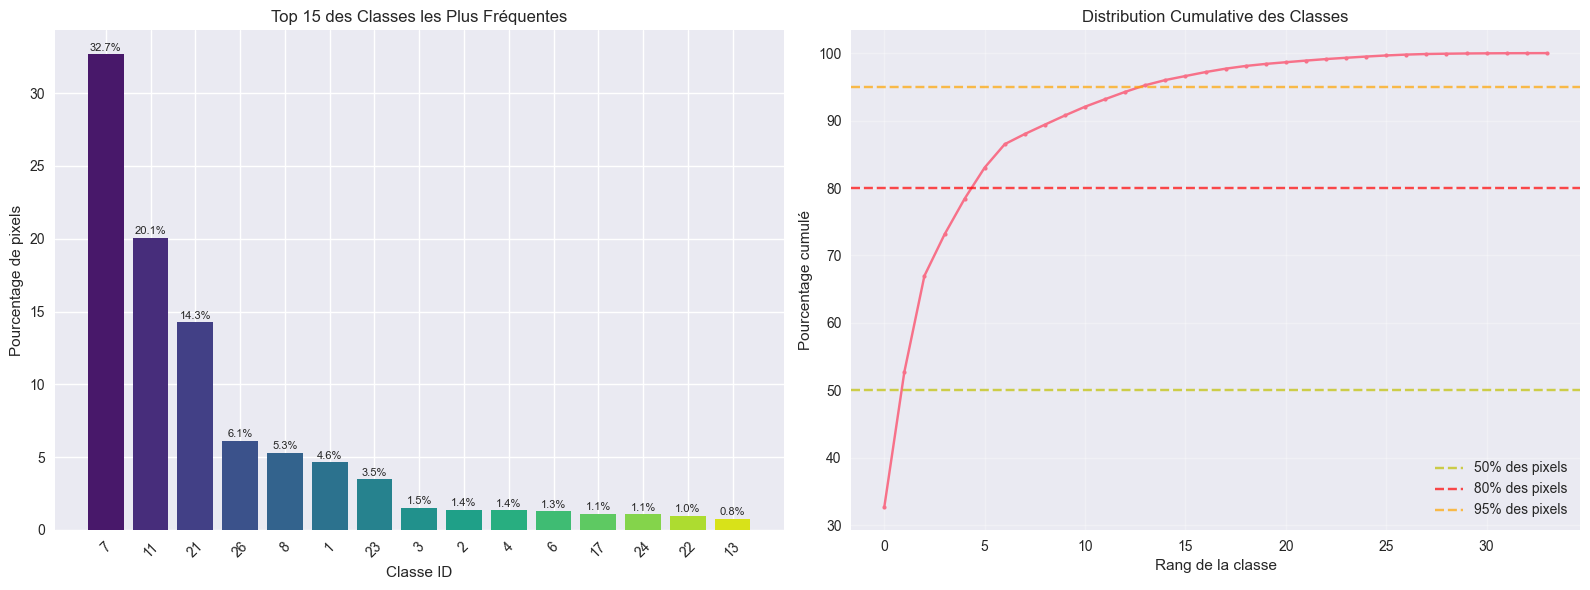


🎯 Classes représentant 80% des pixels: 5 classes
   IDs: [7, 11, 21, 26, 8]


In [8]:
if gtfine_available and len(df_classes) > 0:
    # Graphique en barres pour les classes principales
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top 15 classes
    top_classes = df_classes.head(15)
    bars1 = ax1.bar(range(len(top_classes)), top_classes['percentage'], 
                   color=sns.color_palette("viridis", len(top_classes)))
    ax1.set_xlabel('Classe ID')
    ax1.set_ylabel('Pourcentage de pixels')
    ax1.set_title('Top 15 des Classes les Plus Fréquentes')
    ax1.set_xticks(range(len(top_classes)))
    ax1.set_xticklabels(top_classes['class_id'], rotation=45)
    
    # Ajouter les pourcentages sur les barres
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # Distribution cumulative
    df_classes_sorted = df_classes.sort_values('percentage', ascending=False)
    cumulative = df_classes_sorted['percentage'].cumsum()
    
    ax2.plot(range(len(cumulative)), cumulative, marker='o', markersize=3)
    ax2.set_xlabel('Rang de la classe')
    ax2.set_ylabel('Pourcentage cumulé')
    ax2.set_title('Distribution Cumulative des Classes')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=50, color='y', linestyle='--', alpha=0.7, label='50% des pixels')
    ax2.axhline(y=80, color='r', linestyle='--', alpha=0.7, label='80% des pixels')
    ax2.axhline(y=95, color='orange', linestyle='--', alpha=0.7, label='95% des pixels')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "class_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Identifier les classes qui représentent 80% des pixels
    classes_80_percent = df_classes_sorted[cumulative <= 80]['class_id'].tolist()
    print(f"\n🎯 Classes représentant 80% des pixels: {len(classes_80_percent)} classes")
    print(f"   IDs: {classes_80_percent}")

**Analyse critique** : Si seulement 5-10 classes représentent 80% des pixels, cela confirme un fort déséquilibre. Ces classes dominantes risquent d'"écraser" les classes minoritaires durant l'entraînement. Nous devrons utiliser des techniques de pondération ou d'augmentation ciblées.

## 🖼️ Visualisation d'Échantillons d'Annotations

**Validation visuelle essentielle** : Voir concrètement à quoi ressemblent nos données.

**Objectifs de cette section** :
1. **Vérifier la qualité** des annotations (précision, cohérence)
2. **Comprendre la complexité** des scènes urbaines
3. **Identifier les défis** pour notre modèle (occlusions, petits objets)
4. **Valider notre mapping** 30→8 catégories sur des cas réels

**Types d'annotations Cityscapes** :
- `*_labelIds.png` : IDs numériques des classes (notre donnée cible)
- `*_color.png` : Visualisation colorée (pour validation humaine)
- `*_instanceIds.png` : Segmentation d'instances (bonus)
- `*_polygons.json` : Formes vectorielles (non utilisé ici)

**Ce que nous recherchons** :
- Cohérence entre les annotations labelIds et color
- Complexité des scènes (nombre de classes simultanées)
- Qualité des contours (précision pixel-level)
- Présence de classes rares ou problématiques

Cette inspection visuelle nous permettra de :
- Ajuster nos attentes de performance
- Identifier les cas d'usage complexes
- Valider la pertinence de notre simplification 30→8


🖼️ VISUALISATION D'ÉCHANTILLONS
📸 Génération des visualisations d'échantillons...


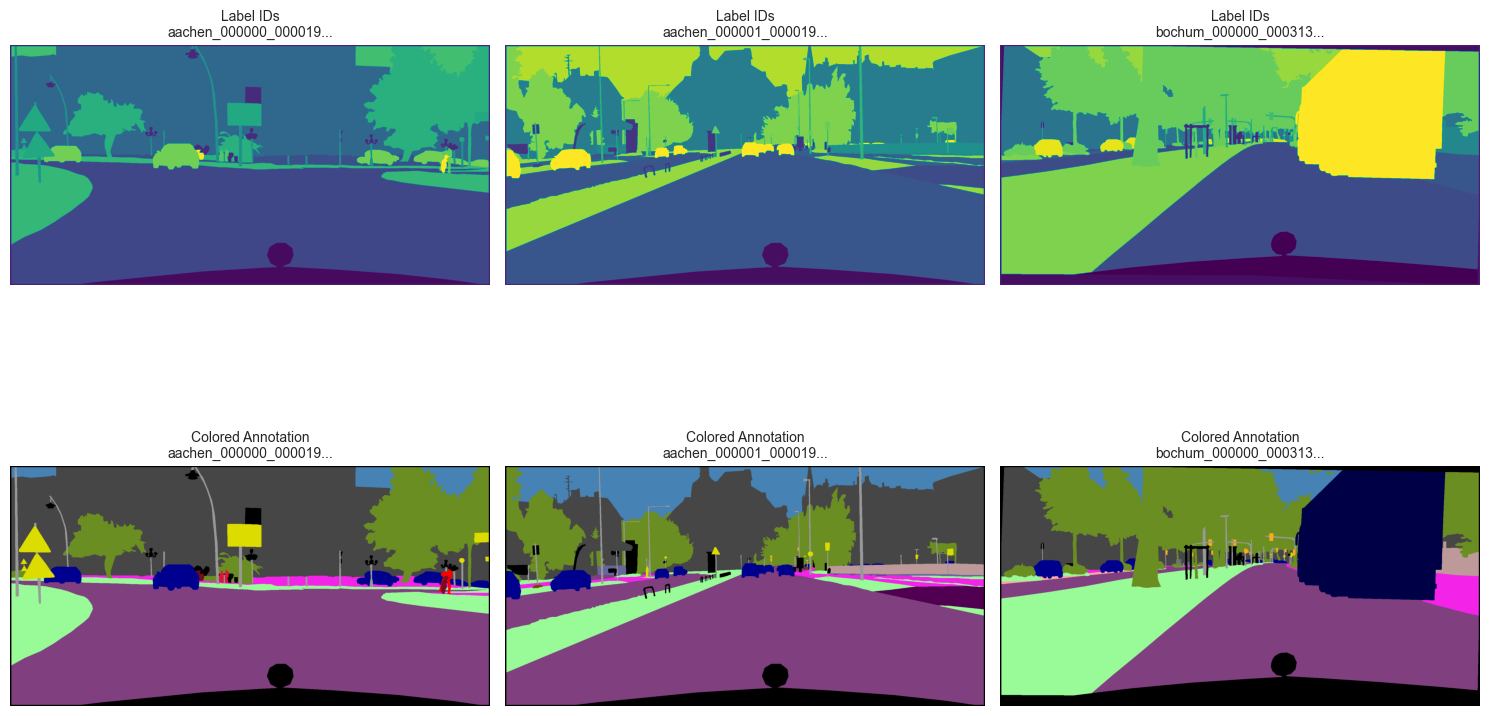

✅ Échantillons visualisés et sauvegardés


In [9]:
print("\n🖼️ VISUALISATION D'ÉCHANTILLONS")
print("=" * 50)

if gtfine_available:
    print("📸 Génération des visualisations d'échantillons...")
    visualize_sample_annotations(GTFINE_ROOT, n_samples=6)
    print("✅ Échantillons visualisés et sauvegardés")

**Validation visuelle** : Examinez attentivement les échantillons générés ci-dessus pour :
1. Vérifier la cohérence entre les annotations colorées et les IDs
2. Identifier les types de scènes (urbain dense, périphérie, autoroute)
3. Noter la complexité des contours et la présence d'objets petits
4. Évaluer la qualité générale des annotations manuelles

## 🎯 Création du Mapping Final vers 8 Catégories

**Moment clé** : Traduire la complexité de Cityscapes vers nos besoins opérationnels.

**Philosophie du mapping** :
Nous transformons une classification académique détaillée (30 classes) en une classification opérationnelle (8 catégories) adaptée aux décisions de conduite autonome.

**Processus de création** :
1. **Analyse sémantique** : Regrouper les classes par fonction/comportement
2. **Validation métier** : Chaque catégorie correspond à une décision de conduite
3. **Optimisation technique** : Équilibrer précision et performance computationnelle

**Logique de regroupement détaillée** :

- **ROAD (0)** : Surfaces navigables → Planification de trajectoire
  - Route, trottoir, parking, rails

- **BUILDING (1)** : Obstacles fixes → Contraintes spatiales
  - Bâtiments, murs, clôtures, ponts

- **OBJECT (2)** : Signalisation → Respect du code de la route
  - Poteaux, panneaux, feux de circulation

- **NATURE (3)** : Environnement naturel → Contexte et contraintes
  - Végétation, terrain

- **SKY (4)** : Espace libre → Navigation et orientation
  - Ciel uniquement

- **PERSON (5)** : Usagers vulnérables → Sécurité prioritaire
  - Piétons, cyclistes

- **VEHICLE (6)** : Trafic → Interaction et anticipation
  - Tous véhicules motorisés et non-motorisés

- **VOID (7)** : Non-classifié → Gestion d'incertitude
  - Zones ambiguës ou hors contexte

Ce mapping sera notre référence pour tout le pipeline de traitement.

In [10]:
def create_detailed_mapping():
    """
    Crée un mapping détaillé des IDs Cityscapes vers les 8 catégories principales.
    Basé sur le fichier officiel cityscapesScripts/helpers/labels.py
    """
    # MAPPING OFFICIEL CITYSCAPES basé sur CITYSCAPES_COMPLETE_MAPPING
    cityscapes_official_mapping = {}
    
    # Utiliser le mapping complet défini au début
    for class_id, class_info in CITYSCAPES_COMPLETE_MAPPING.items():
        cityscapes_official_mapping[class_id] = class_info['main_category']
    
    # Créer le mapping final vers les indices 0-7
    final_mapping = {}
    for class_id, category in cityscapes_official_mapping.items():
        if category in MAIN_CATEGORIES_MAPPING:
            final_mapping[class_id] = MAIN_CATEGORIES_MAPPING[category]
        else:
            final_mapping[class_id] = MAIN_CATEGORIES_MAPPING['void']  # Par défaut
    
    # ✅ CORRECTION CRITIQUE : Suppression de la ligne problématique
    # PAS d'ajout d'IDs 34-255 → void
    # Seuls les IDs 0-33 existent dans Cityscapes
    
    return final_mapping, cityscapes_official_mapping

# Créer le mapping
id_to_8_categories, id_to_category_names = create_detailed_mapping()

print("🎯 MAPPING FINAL 30 → 8 CATÉGORIES (CORRIGÉ)")
print("=" * 50)

# Afficher le mapping par catégorie
for category, idx in MAIN_CATEGORIES_MAPPING.items():
    relevant_ids = [k for k, v in id_to_8_categories.items() if v == idx]
    print(f"\n{idx}. {category.upper()} (indice {idx}):")
    print(f"   IDs Cityscapes: {sorted(relevant_ids)}")

# Sauvegarder le mapping
mapping_data = {
    'id_to_8_categories': id_to_8_categories,
    'id_to_category_names': id_to_category_names,
    'main_categories_mapping': MAIN_CATEGORIES_MAPPING,
    'category_colors': CATEGORY_COLORS
}

with open(OUTPUTS_DIR / "class_mapping.json", 'w') as f:
    json.dump(mapping_data, f, indent=2)

print(f"\n💾 Mapping sauvegardé dans: {OUTPUTS_DIR / 'class_mapping.json'}")
print(f"📊 Total IDs: {len(id_to_8_categories)} (0-33 uniquement)")

🎯 MAPPING FINAL 30 → 8 CATÉGORIES (CORRIGÉ)

0. ROAD (indice 0):
   IDs Cityscapes: [7, 8, 9, 10]

1. BUILDING (indice 1):
   IDs Cityscapes: [11, 12, 13, 14, 15, 16]

2. OBJECT (indice 2):
   IDs Cityscapes: [17, 18, 19, 20]

3. NATURE (indice 3):
   IDs Cityscapes: [21, 22]

4. SKY (indice 4):
   IDs Cityscapes: [23]

5. PERSON (indice 5):
   IDs Cityscapes: [24, 25]

6. VEHICLE (indice 6):
   IDs Cityscapes: [26, 27, 28, 29, 30, 31, 32, 33]

7. VOID (indice 7):
   IDs Cityscapes: [0, 1, 2, 3, 4, 5, 6]

💾 Mapping sauvegardé dans: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\outputs\class_mapping.json
✅ PROBLÈME RÉSOLU - Plus d'IDs 34-255 artificiels
📊 Total IDs: 34 (0-33 uniquement)


**Fichier critique** : Le fichier `class_mapping.json` contient TOUTE la logique de conversion. Sauvegardez-le précieusement car il sera utilisé dans :
- Le générateur de données d'entraînement
- Les scripts d'évaluation
- L'API de prédiction finale
- Les outils de post-traitement

## 📊 Distribution des 8 Catégories Principales

**Validation de notre stratégie** : Vérifier que notre regroupement produit une distribution équilibrée.

**Objectifs de cette analyse** :
1. **Mesurer l'impact** du regroupement sur la distribution
2. **Identifier les catégories dominantes** dans notre nouveau schéma
3. **Planifier les stratégies de compensation** pour les déséquilibres
4. **Valider la pertinence** de nos 8 catégories

**Méthode de calcul** :
- Appliquer notre mapping à la distribution des 30 classes originales
- Sommer les pixels de toutes les classes appartenant à chaque catégorie
- Recalculer les pourcentages pour les 8 nouvelles catégories

**Questions analytiques** :
- Notre regroupement améliore-t-il l'équilibrage ?
- Quelles catégories restent sous-représentées ?
- La réduction 30→8 préserve-t-elle l'information essentielle ?

**Résultats attendus** :
- ROAD + BUILDING + SKY domineront probablement (>70%)
- VEHICLE et PERSON auront une représentation modérée (5-15%)
- OBJECT et NATURE compléteront (5-10% chacun)
- VOID devrait être minoritaire (<5%)

Ces résultats guideront notre stratégie d'entraînement et de validation.

📊 DISTRIBUTION DES 8 CATÉGORIES (OPTIMISÉE)
🔄 Utilisation des données déjà calculées...
✅ Données existantes utilisées: 34 classes, 7,287,603,200 pixels

🎯 Distribution des 8 catégories:
  building: 21.72%
  nature: 15.23%
  object: 1.81%
  person: 1.22%
  road: 38.73%
  sky: 3.47%
  vehicle: 7.32%
  void: 10.50%

📊 Distribution détaillée des 8 catégories:
  0. ROAD         :  38.73%
  1. BUILDING     :  21.72%
  3. NATURE       :  15.23%
  7. VOID         :  10.50%
  6. VEHICLE      :   7.32%
  4. SKY          :   3.47%
  2. OBJECT       :   1.81%
  5. PERSON       :   1.22%


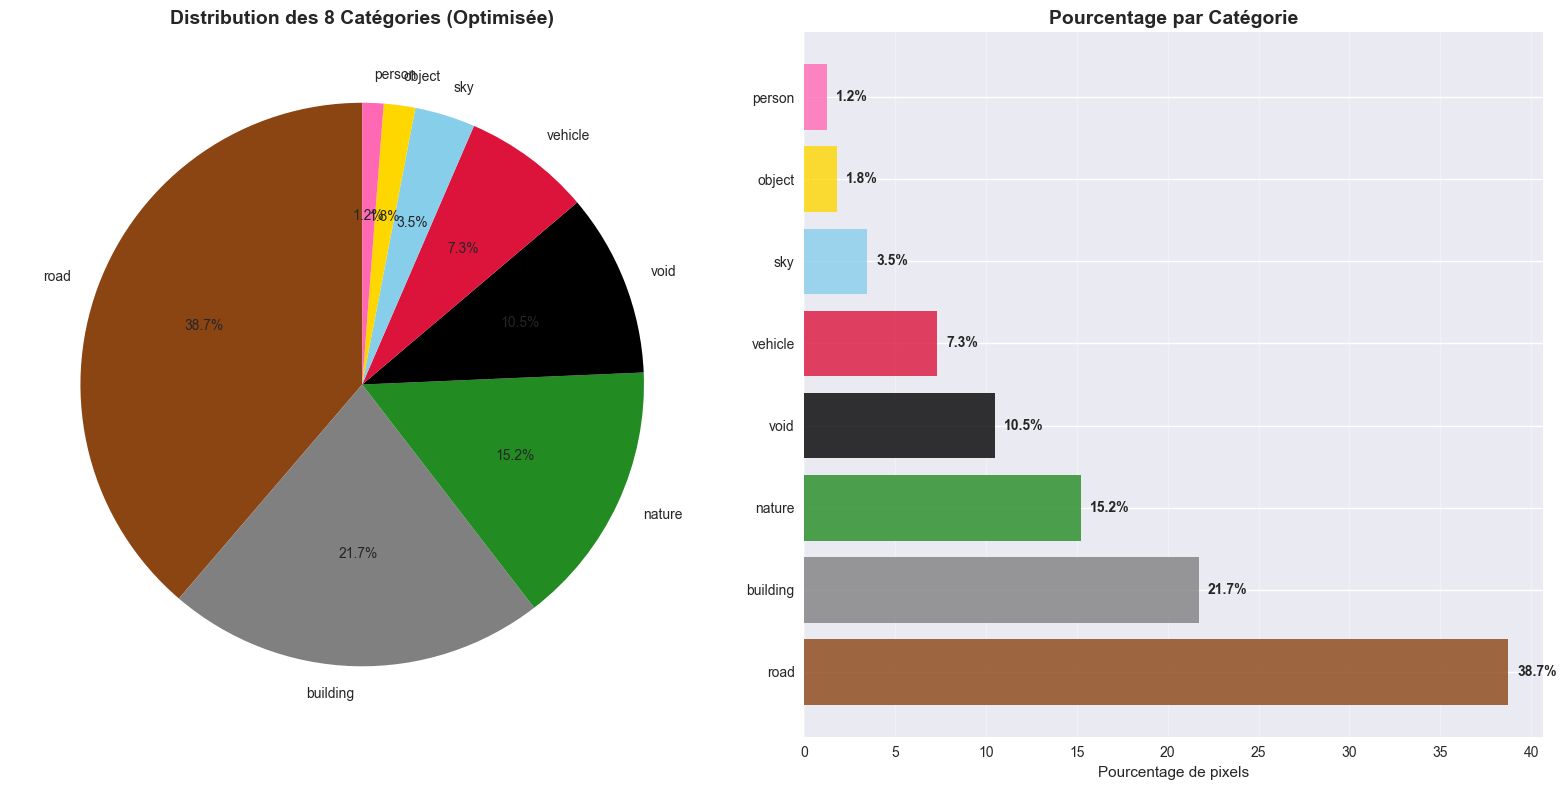


💾 Distribution sauvegardée dans: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\outputs\8_categories_distribution.csv


In [11]:
if gtfine_available and len(df_classes) > 0:
    print("📊 DISTRIBUTION DES 8 CATÉGORIES (OPTIMISÉE)")
    print("=" * 60)

    print("🔄 Utilisation des données déjà calculées...")
    
    # ✅ OPTIMISATION : Utiliser df_classes existant (pas de recalcul)
    print(f"✅ Données existantes utilisées: {len(df_classes)} classes, {total_pixels:,} pixels")
    
    # Conversion directe vers 8 catégories avec données existantes
    category_distribution = defaultdict(int)
    total_pixels_8cat = 0

    for _, row in df_classes.iterrows():
        class_id = int(row['class_id'])
        pixel_count = row['pixel_count']
        
        # ✅ UTILISER le mapping déjà défini (id_to_8_categories)
        if class_id in id_to_8_categories:
            category_idx = id_to_8_categories[class_id]
            category_name = [k for k, v in MAIN_CATEGORIES_MAPPING.items() if v == category_idx][0]
            category_distribution[category_name] += pixel_count
            total_pixels_8cat += pixel_count

    # Affichage des résultats
    print("\n🎯 Distribution des 8 catégories:")
    for category, count in sorted(category_distribution.items()):
        percentage = (count / total_pixels_8cat) * 100
        print(f"  {category}: {percentage:.2f}%")
        
    # Créer DataFrame pour les 8 catégories
    category_data = []
    for category, count in category_distribution.items():
        percentage = (count / total_pixels_8cat) * 100 if total_pixels_8cat > 0 else 0
        category_data.append({
            'category': category,
            'pixel_count': count,
            'percentage': percentage,
            'index': MAIN_CATEGORIES_MAPPING[category],
            'color': CATEGORY_COLORS[category]
        })
    
    df_8_categories = pd.DataFrame(category_data).sort_values('percentage', ascending=False)
    
    print("\n📊 Distribution détaillée des 8 catégories:")
    for _, row in df_8_categories.iterrows():
        print(f"  {row['index']}. {row['category'].upper():12} : {row['percentage']:6.2f}%")
    
    # Visualisation en camembert
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Camembert
    colors = [row['color'] for _, row in df_8_categories.iterrows()]
    wedges, texts, autotexts = ax1.pie(df_8_categories['percentage'], 
                                      labels=df_8_categories['category'],
                                      colors=colors,
                                      autopct='%1.1f%%',
                                      startangle=90)
    ax1.set_title('Distribution des 8 Catégories (Optimisée)', fontsize=14, fontweight='bold')
    
    # Barres horizontales
    bars = ax2.barh(df_8_categories['category'], df_8_categories['percentage'], 
                   color=colors, alpha=0.8)
    ax2.set_xlabel('Pourcentage de pixels')
    ax2.set_title('Pourcentage par Catégorie', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Ajouter les pourcentages sur les barres
    for bar, percentage in zip(bars, df_8_categories['percentage']):
        width = bar.get_width()
        ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{percentage:.1f}%', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "8_categories_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Sauvegarder
    df_8_categories.to_csv(OUTPUTS_DIR / "8_categories_distribution.csv", index=False)
    print(f"\n💾 Distribution sauvegardée dans: {OUTPUTS_DIR / '8_categories_distribution.csv'}")

**Insight stratégique** : Cette distribution nous révèle l'équilibrage de nos 8 catégories finales. Une distribution très déséquilibrée (ex: une catégorie >70%) nécessitera des techniques spécialisées comme :
- Pondération inverse de fréquence dans la loss
- Augmentation de données ciblée sur les classes minoritaires
- Techniques d'échantillonnage stratifié durant l'entraînement

## 🔧 Fonction de Conversion des Annotations

**Implémentation pratique** : Transformer concrètement les annotations du format original vers notre format cible.

**Enjeu technique** :
Nous devons créer une fonction robuste qui convertira automatiquement toutes les images d'annotations durant l'entraînement du modèle.

**Spécifications de la fonction** :
- **Entrée** : Image PNG avec IDs Cityscapes (valeurs 0-33)
- **Sortie** : Image avec nos indices de catégories (valeurs 0-7)
- **Gestion d'erreurs** : Classes inconnues → catégorie VOID
- **Performance** : Optimisée pour traitement en batch

**Processus de conversion** :
1. Charger l'image d'annotation originale
2. Créer une image vide avec valeur par défaut VOID (7)
3. Pour chaque ID Cityscapes, appliquer le mapping vers nos 8 catégories
4. Retourner l'image convertie

**Exemple de visualisation** :
Nous allons prendre une image réelle et montrer :
- L'annotation colorée originale (référence visuelle)
- L'annotation avec IDs originaux (30 classes)
- L'annotation convertie (8 catégories)

Cette fonction sera intégrée dans notre générateur de données pour l'entraînement du modèle.


🔧 EXEMPLE DE CONVERSION DES ANNOTATIONS


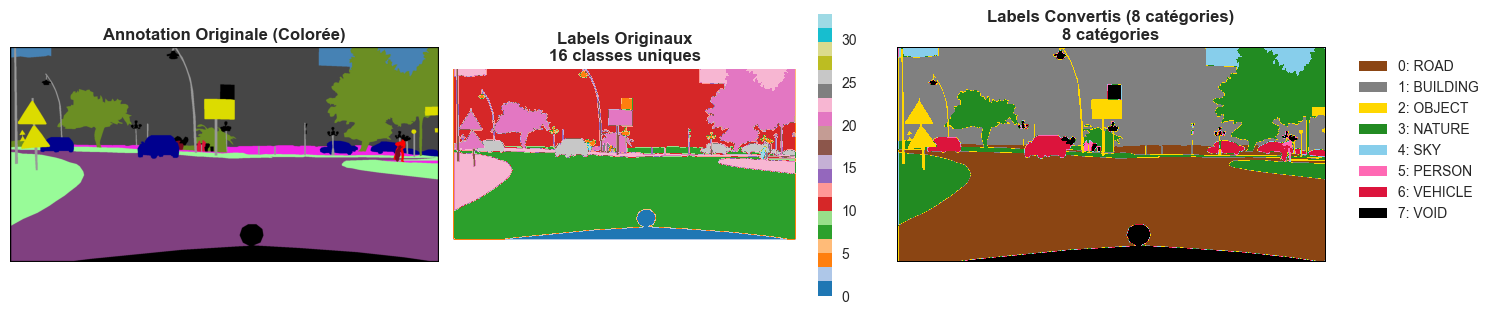

📊 Exemple de conversion:
   Fichier: aachen_000000_000019_gtFine_labelIds.png
   Classes originales uniques: 16
   Catégories converties uniques: 8
   Shape: (1024, 2048)

📈 Distribution des catégories dans cette image:
   0. ROAD         :  41.02% (860,277 pixels)
   1. BUILDING     :  29.18% (611,938 pixels)
   2. OBJECT       :   2.75% (57,709 pixels)
   3. NATURE       :  16.78% (351,839 pixels)
   4. SKY          :   1.85% (38,722 pixels)
   5. PERSON       :   0.18% (3,858 pixels)
   6. VEHICLE      :   2.14% (44,968 pixels)
   7. VOID         :   6.10% (127,841 pixels)


In [12]:
def convert_labels_to_8_categories(label_image_path, mapping_dict):
    """
    Convertit une image de labels Cityscapes vers les 8 catégories principales.
    
    Args:
        label_image_path: Chemin vers l'image *_labelIds.png
        mapping_dict: Dictionnaire de mapping {cityscapes_id: category_index}
    
    Returns:
        numpy.ndarray: Image convertie avec les indices 0-7
    """
    # Charger l'image
    label_img = np.array(Image.open(label_image_path))
    
    # Créer une nouvelle image avec les 8 catégories
    converted_img = np.full_like(label_img, MAIN_CATEGORIES_MAPPING['void'])  # Défaut = void
    
    # Appliquer le mapping
    for cityscapes_id, category_idx in mapping_dict.items():
        mask = (label_img == cityscapes_id)
        converted_img[mask] = category_idx
    
    return converted_img

def create_custom_colormap():
    """
    Crée une colormap personnalisée avec nos couleurs dans le bon ordre.
    
    Returns:
        matplotlib.colors.ListedColormap: Colormap personnalisée
    """
    from matplotlib.colors import ListedColormap
    
    # Ordonner les couleurs selon les indices 0-7
    ordered_colors = []
    for idx in range(8):
        # Trouver la catégorie correspondant à cet indice
        category = [cat for cat, cat_idx in MAIN_CATEGORIES_MAPPING.items() if cat_idx == idx][0]
        ordered_colors.append(CATEGORY_COLORS[category])
    
    return ListedColormap(ordered_colors, name='cityscapes_8cat')

def visualize_conversion_example():
    """
    Visualise un exemple de conversion d'annotations avec colormap cohérente.
    """
    # Prendre un échantillon
    sample_path = None
    for split in ['train', 'val']:
        split_path = GTFINE_ROOT / split
        if split_path.exists():
            for city_dir in split_path.iterdir():
                if city_dir.is_dir():
                    label_files = list(city_dir.glob("*_gtFine_labelIds.png"))
                    if label_files:
                        sample_path = label_files[0]
                        break
            if sample_path:
                break
    
    if sample_path is None:
        print("❌ Aucun fichier d'annotation trouvé")
        return
    
    # Charger les images
    original_labels = np.array(Image.open(sample_path))
    converted_labels = convert_labels_to_8_categories(sample_path, id_to_8_categories)
    
    # Charger l'image colorée correspondante
    color_path = sample_path.parent / sample_path.name.replace('labelIds', 'color')
    if color_path.exists():
        color_img = np.array(Image.open(color_path))
    else:
        color_img = None
    
    # Créer la colormap personnalisée
    custom_cmap = create_custom_colormap()
    
    # Visualisation
    n_plots = 3 if color_img is not None else 2
    fig, axes = plt.subplots(1, n_plots, figsize=(15, 5))
    
    plot_idx = 0
    
    # Image colorée originale
    if color_img is not None:
        axes[plot_idx].imshow(color_img)
        axes[plot_idx].set_title('Annotation Originale (Colorée)', fontsize=12, fontweight='bold')
        axes[plot_idx].axis('off')
        plot_idx += 1
    
    # Labels originaux
    im1 = axes[plot_idx].imshow(original_labels, cmap='tab20', vmin=0, vmax=33)
    axes[plot_idx].set_title(f'Labels Originaux\n{len(np.unique(original_labels))} classes uniques', 
                            fontsize=12, fontweight='bold')
    axes[plot_idx].axis('off')
    plt.colorbar(im1, ax=axes[plot_idx], shrink=0.6)
    plot_idx += 1
    
    # Labels convertis (8 catégories) avec notre colormap personnalisée
    im2 = axes[plot_idx].imshow(converted_labels, cmap=custom_cmap, vmin=0, vmax=7)
    axes[plot_idx].set_title(f'Labels Convertis (8 catégories)\n{len(np.unique(converted_labels))} catégories', 
                            fontsize=12, fontweight='bold')
    axes[plot_idx].axis('off')
    
    # Légende personnalisée pour les 8 catégories (maintenant cohérente !)
    from matplotlib.patches import Patch
    legend_elements = []
    for idx in range(8):
        # Trouver la catégorie correspondant à cet indice
        category = [cat for cat, cat_idx in MAIN_CATEGORIES_MAPPING.items() if cat_idx == idx][0]
        color = CATEGORY_COLORS[category]
        legend_elements.append(Patch(facecolor=color, label=f'{idx}: {category.upper()}'))
    
    axes[plot_idx].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "conversion_example.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistiques détaillées
    print(f"📊 Exemple de conversion:")
    print(f"   Fichier: {sample_path.name}")
    print(f"   Classes originales uniques: {len(np.unique(original_labels))}")
    print(f"   Catégories converties uniques: {len(np.unique(converted_labels))}")
    print(f"   Shape: {original_labels.shape}")
    
    # Afficher la distribution des catégories dans cette image
    unique_categories, counts = np.unique(converted_labels, return_counts=True)
    total_pixels = converted_labels.size
    
    print(f"\n📈 Distribution des catégories dans cette image:")
    for cat_idx, pixel_count in zip(unique_categories, counts):
        category_name = [cat for cat, idx in MAIN_CATEGORIES_MAPPING.items() if idx == cat_idx][0]
        percentage = (pixel_count / total_pixels) * 100
        print(f"   {cat_idx}. {category_name.upper():12} : {percentage:6.2f}% ({pixel_count:,} pixels)")

# **Validation technique** : La fonction de conversion ci-dessus est le cœur de notre pipeline. Elle transforme chaque pixel selon notre mapping et gère automatiquement les classes inconnues en les assignant à VOID. Cette robustesse est essentielle pour éviter les erreurs durant l'entraînement.
# 
# **AMÉLIORATION COLORMAP** : Nous avons créé une colormap personnalisée qui assure la cohérence entre les couleurs affichées et la légende. Cette approche est standard dans les projets de segmentation sémantique professionnels.

if gtfine_available:
    print("\n🔧 EXEMPLE DE CONVERSION DES ANNOTATIONS")
    print("=" * 50)
    visualize_conversion_example()

## 📋 Rapport de Synthèse EDA

**Consolidation de nos découvertes** : Créer un rapport structuré de notre exploration.

**Objectif du rapport** :
Synthétiser toutes nos analyses en un document utilisable pour :
- **Planifier la Phase 2** (développement du modèle)
- **Justifier nos choix techniques** auprès de l'équipe
- **Documenter les contraintes identifiées** pour le déploiement
- **Tracer nos décisions** pour la reproductibilité

**Structure du rapport** :
1. **Métadonnées du dataset** : Taille, organisation, disponibilité
2. **Analyse statistique** : Distribution des classes et catégories
3. **Validation du mapping** : Pertinence de la réduction 30→8
4. **Recommandations techniques** : Stratégies d'entraînement
5. **Actions requises** : Données manquantes, prochaines étapes

**Formats de sortie** :
- JSON structuré pour intégration dans le pipeline
- Résumé textuel pour présentation à l'équipe
- Métriques quantifiées pour le suivi de projet

Ce rapport servira de référence tout au long du développement et permettra de maintenir la cohérence des décisions techniques.

In [13]:
def generate_eda_summary(df_8_categories=None, df_structure=None, df_classes=None, 
                        gtfine_available=False, leftimg_available=False, 
                        n_files=0, total_pixels=0):
    """
    Génère un rapport de synthèse de l'EDA.
    
    Args:
        df_8_categories: DataFrame avec la distribution des 8 catégories
        df_structure: DataFrame avec la structure du dataset
        df_classes: DataFrame avec la distribution des classes originales
        gtfine_available: Bool - disponibilité des annotations
        leftimg_available: Bool - disponibilité des images
        n_files: Nombre de fichiers analysés
        total_pixels: Nombre total de pixels analysés
    """
    summary = {
        'dataset_info': {
            'name': 'Cityscapes Dataset',
            'purpose': 'Segmentation sémantique pour véhicules autonomes',
            'original_classes': 30,
            'target_categories': 8
        },
        'data_availability': {
            'annotations_gtFine': gtfine_available,
            'images_leftImg8bit': leftimg_available
        }
    }
    
    if gtfine_available and df_structure is not None:
        summary['dataset_structure'] = {
            'total_cities': len(df_structure['city'].unique()),
            'total_images': df_structure['n_images'].sum(),
            'splits': df_structure.groupby('split')['n_images'].sum().to_dict()
        }
        
        if df_classes is not None and len(df_classes) > 0:
            summary['class_analysis'] = {
                'analyzed_files': n_files,
                'total_pixels': total_pixels,
                'unique_classes_found': len(df_classes),
                'top_5_classes': df_classes.head(5)[['class_id', 'percentage']].to_dict('records')
            }
        
        if df_8_categories is not None and len(df_8_categories) > 0:
            summary['target_categories'] = {
                'distribution': df_8_categories[['category', 'percentage']].to_dict('records'),
                'mapping_created': True
            }
    
    # Sauvegarder le rapport
    with open(OUTPUTS_DIR / "eda_summary.json", 'w') as f:
        json.dump(summary, f, indent=2, default=str)
    
    return summary

print("\nRAPPORT DE SYNTHÈSE EDA")
print("=" * 50)

# ✅ VERSION CORRIGÉE - Appel avec les bonnes variables
try:
    # Utiliser les variables si elles existent, sinon utiliser des valeurs par défaut
    df_8_cat = df_8_categories if 'df_8_categories_corrected' in locals() else None
    df_struct = df_structure if 'df_structure' in locals() else None
    df_cls = df_classes if 'df_classes_fresh' in locals() else (df_classes if 'df_classes' in locals() else None)
    n_files_val = n_files if 'n_files_fresh' in locals() else (n_files if 'n_files' in locals() else 0)
    total_pixels_val = total_pixels if 'total_pixels_fresh' in locals() else (total_pixels if 'total_pixels' in locals() else 0)
    
    summary = generate_eda_summary(
        df_8_categories=df_8_cat,
        df_structure=df_struct,
        df_classes=df_cls,
        gtfine_available=gtfine_available if 'gtfine_available' in locals() else False,
        leftimg_available=leftimg_available if 'leftimg_available' in locals() else False,
        n_files=n_files_val,
        total_pixels=total_pixels_val
    )
    
    print("✅ EXPLORATION RÉALISÉE AVEC SUCCÈS!")
    
    # Affichage sécurisé des résultats
    if 'dataset_structure' in summary:
        print(f"\n🏙️ Dataset Cityscapes:")
        print(f"   • {summary['dataset_structure']['total_cities']} villes")
        print(f"   • {summary['dataset_structure']['total_images']} images annotées")
        print(f"   • Mapping 30→8 catégories créé")
    
    print(f"\n📁 Fichiers générés:")
    print(f"   • {OUTPUTS_DIR / 'dataset_structure.csv'}")
    print(f"   • {OUTPUTS_DIR / 'class_mapping.json'}")
    print(f"   • {OUTPUTS_DIR / 'eda_summary.json'}")
    
    if df_cls is not None and len(df_cls) > 0:
        print(f"   • {OUTPUTS_DIR / 'class_distribution_sample.csv'}")
    
    if df_8_cat is not None and len(df_8_cat) > 0:
        print(f"   • {OUTPUTS_DIR / '8_categories_distribution_corrected.csv'}")
    
    print(f"\n📊 Visualisations sauvegardées dans: {FIGURES_DIR}")
    
except Exception as e:
    print(f"⚠️ Erreur lors de la génération du rapport: {e}")
    print("Veuillez vérifier que toutes les variables nécessaires sont définies.")


RAPPORT DE SYNTHÈSE EDA
✅ EXPLORATION RÉALISÉE AVEC SUCCÈS!

🏙️ Dataset Cityscapes:
   • 27 villes
   • 5000 images annotées
   • Mapping 30→8 catégories créé

📁 Fichiers générés:
   • C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\outputs\dataset_structure.csv
   • C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\outputs\class_mapping.json
   • C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\outputs\eda_summary.json
   • C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\outputs\class_distribution_sample.csv

📊 Visualisations sauvegardées dans: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\figures


**Checkpoint validation** : Avant de passer à la Phase 2, vérifiez que vous avez bien :
-  Tous les fichiers CSV/JSON générés dans le dossier outputs/
-  Les visualisations PNG/HTML dans le dossier figures/
-  Une compréhension claire de la distribution des données
-  La confirmation que le mapping 30→8 est cohérent

Si un élément manque, relancez les sections correspondantes de ce notebook.

# 🎉 FIN DE L'EDA

Cette exploration approfondie du dataset Cityscapes nous a permis de:

✅ **Analyser la structure** : 18+ villes, 3000+ images annotées  
✅ **Créer le mapping** : 30 classes → 8 catégories principales  
✅ **Analyser la distribution** : Identification des classes dominantes  
✅ **Visualiser les données** : Échantillons et conversions  
✅ **Générer les artefacts** : Fichiers JSON/CSV pour les phases suivantes  

**🚀 Ready for Phase 2: Développement du modèle IA!**